# OTSU Big Data Cloud notebook

In [1]:
import gcsfs
import rioxarray
import rasterio
import os
import numpy as np
from distributed import Client
import xarray as xr

In [2]:
import os

def set_env():
    os.environ["GS_NO_SIGN_REQUEST"] = "YES"

set_env()

## Accès à un bucket GCP

In [3]:
import gcsfs
fs = gcsfs.GCSFileSystem(bucket_name="supaero", token='anon')

In [4]:
fs.ls('supaero/31TCH')

['supaero/31TCH/SENTINEL2A_20190804-105917-289_L2A_T31TCH_C_V2-2',
 'supaero/31TCH/SENTINEL2A_20191003-105914-893_L2A_T31TCH_C_V2-2',
 'supaero/31TCH/SENTINEL2A_20200210-105905-458_L2A_T31TCH_C_V2-2',
 'supaero/31TCH/SENTINEL2A_20200318-104912-044_L2A_T31TCH_C_V2-2',
 'supaero/31TCH/SENTINEL2B_20190401-105915-368_L2A_T31TCH_C_V2-0',
 'supaero/31TCH/SENTINEL2B_20190528-104924-205_L2A_T31TCH_C_V2-1',
 'supaero/31TCH/SENTINEL2B_20190630-105921-483_L2A_T31TCH_C_V2-2',
 'supaero/31TCH/SENTINEL2B_20190720-105921-577_L2A_T31TCH_C_V2-2',
 'supaero/31TCH/SENTINEL2B_20191117-105911-155_L2A_T31TCH_C_V2-2',
 'supaero/31TCH/SENTINEL2B_20191224-104910-788_L2A_T31TCH_C_V2-2']

In [5]:
fs.ls('supaero/31TCH/SENTINEL2B_20191224-104910-788_L2A_T31TCH_C_V2-2')

['supaero/31TCH/SENTINEL2B_20191224-104910-788_L2A_T31TCH_C_V2-2/DATA',
 'supaero/31TCH/SENTINEL2B_20191224-104910-788_L2A_T31TCH_C_V2-2/MASKS',
 'supaero/31TCH/SENTINEL2B_20191224-104910-788_L2A_T31TCH_C_V2-2/SENTINEL2B_20191224-104910-788_L2A_T31TCH_C_V2-2_ATB_R1.tif',
 'supaero/31TCH/SENTINEL2B_20191224-104910-788_L2A_T31TCH_C_V2-2/SENTINEL2B_20191224-104910-788_L2A_T31TCH_C_V2-2_ATB_R2.tif',
 'supaero/31TCH/SENTINEL2B_20191224-104910-788_L2A_T31TCH_C_V2-2/SENTINEL2B_20191224-104910-788_L2A_T31TCH_C_V2-2_FRE_B11.tif',
 'supaero/31TCH/SENTINEL2B_20191224-104910-788_L2A_T31TCH_C_V2-2/SENTINEL2B_20191224-104910-788_L2A_T31TCH_C_V2-2_FRE_B12.tif',
 'supaero/31TCH/SENTINEL2B_20191224-104910-788_L2A_T31TCH_C_V2-2/SENTINEL2B_20191224-104910-788_L2A_T31TCH_C_V2-2_FRE_B2.tif',
 'supaero/31TCH/SENTINEL2B_20191224-104910-788_L2A_T31TCH_C_V2-2/SENTINEL2B_20191224-104910-788_L2A_T31TCH_C_V2-2_FRE_B3.tif',
 'supaero/31TCH/SENTINEL2B_20191224-104910-788_L2A_T31TCH_C_V2-2/SENTINEL2B_20191224-104910

## Lecture d'une bande avec rioxarray, et affichage d'un sous ensemble

Seul les pixels sélectionnés sont chargés.

In [6]:
xds_11 = rioxarray.open_rasterio("gs://supaero/31TCH/SENTINEL2B_20191224-104910-788_L2A_T31TCH_C_V2-2/SENTINEL2B_20191224-104910-788_L2A_T31TCH_C_V2-2_FRE_B11.tif", nodata=-10000.0)
xds_11 = xds_11[:,4000:5000,4000:5000]
xds_11

<xarray.DataArray (band: 1, y: 1000, x: 1000)> Size: 2MB
[1000000 values with dtype=int16]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 8kB 3.8e+05 3.8e+05 3.8e+05 ... 4e+05 4e+05 4e+05
  * y            (y) float64 8kB 4.72e+06 4.72e+06 4.72e+06 ... 4.7e+06 4.7e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

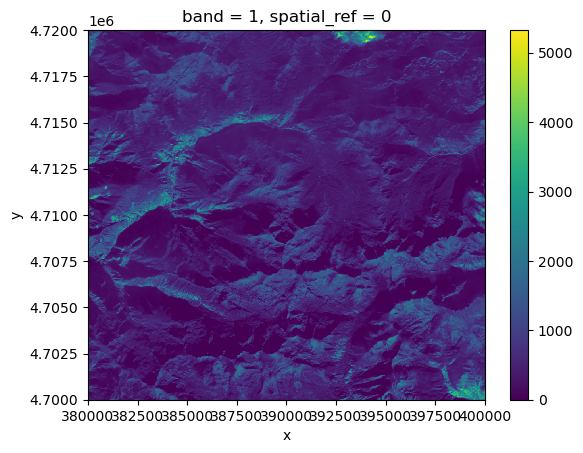

In [7]:
xds_11.plot()

## Construction d'un Dataset monotemporel

Sans Dask, Bande GREEN et SWIR, sous ensemble, rééchantillonage, calcul du NDSI

In [8]:
green = rioxarray.open_rasterio("gs://supaero/31TCH/SENTINEL2B_20191224-104910-788_L2A_T31TCH_C_V2-2/SENTINEL2B_20191224-104910-788_L2A_T31TCH_C_V2-2_FRE_B3.tif")
green = green[:,8000:10000,8000:10000]
# Rééchantillonage à 20m, diviser résolution par 2
green = green.coarsen(x=2, y=2, boundary='pad').mean()
#No data
green = green.where(green != -10000)
green.rio.write_nodata(-10000, encoded=True, inplace=True)
green

<xarray.DataArray (band: 1, y: 1000, x: 1000)> Size: 4MB
array([[[ 132.75,  198.5 ,  169.  , ..., 1281.  , 1498.75, 1141.75],
        [ 145.  ,  168.  ,  139.5 , ...,  994.25, 1364.25,  918.75],
        [ 139.  ,  112.25,  158.  , ..., 1267.5 , 1268.25, 1509.75],
        ...,
        [   0.  ,    0.  ,    0.  , ..., 1376.  ,  981.  , 1111.25],
        [   0.  ,    0.  ,    0.  , ..., 1296.5 , 1271.5 , 1209.75],
        [   0.  ,    0.  ,    0.  , ..., 1320.  , 1531.5 , 1488.25]]],
      dtype=float32)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 8kB 3.8e+05 3.8e+05 3.8e+05 ... 4e+05 4e+05 4e+05
  * y            (y) float64 8kB 4.72e+06 4.72e+06 4.72e+06 ... 4.7e+06 4.7e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

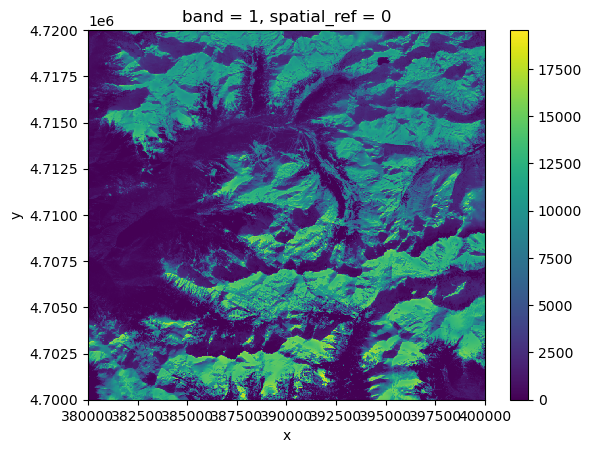

In [9]:
green.plot()

In [10]:
swir = rioxarray.open_rasterio("gs://supaero/31TCH/SENTINEL2B_20191224-104910-788_L2A_T31TCH_C_V2-2/SENTINEL2B_20191224-104910-788_L2A_T31TCH_C_V2-2_FRE_B11.tif")
swir = swir[:,4000:5000,4000:5000]
#No data
swir = swir.where(swir != -10000)
swir.rio.write_nodata(-10000, encoded=True, inplace=True)
swir

<xarray.DataArray (band: 1, y: 1000, x: 1000)> Size: 4MB
array([[[ 770.,  846.,  814., ...,  257.,  277.,  314.],
        [ 761.,  740.,  704., ...,  287.,  297.,  295.],
        [ 761.,  667.,  669., ...,  281.,  256.,  246.],
        ...,
        [ 566.,  557.,  524., ..., 2321., 2345., 2834.],
        [ 575.,  538.,  494., ..., 2195., 2398., 2837.],
        [ 545.,  510.,  454., ..., 2260., 2314., 2576.]]], dtype=float32)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 8kB 3.8e+05 3.8e+05 3.8e+05 ... 4e+05 4e+05 4e+05
  * y            (y) float64 8kB 4.72e+06 4.72e+06 4.72e+06 ... 4.7e+06 4.7e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

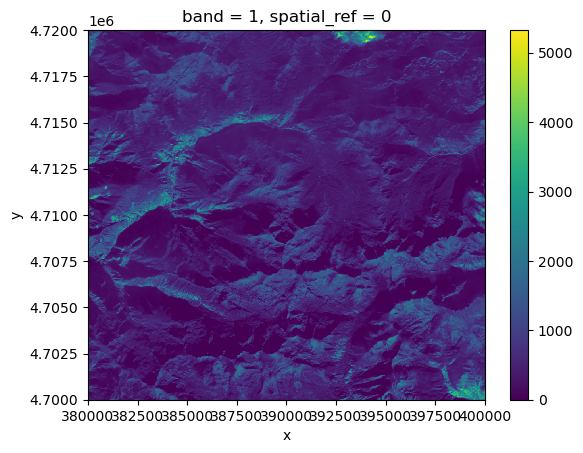

In [11]:
swir.plot()

In [12]:
ndsi = (green - swir) / (green + swir)
ndsi

<xarray.DataArray (band: 1, y: 1000, x: 1000)> Size: 4MB
array([[[-0.70589864, -0.6199138 , -0.65615463, ...,  0.66579974,
          0.68801916,  0.5686073 ],
        [-0.6799117 , -0.62995595, -0.66923535, ...,  0.552     ,
          0.64243793,  0.5139032 ],
        [-0.6911111 , -0.7119025 , -0.617896  , ...,  0.63706815,
          0.6640971 ,  0.7197779 ],
        ...,
        [-1.        , -1.        , -1.        , ..., -0.25561267,
         -0.41010222, -0.43666434],
        [-1.        , -1.        , -1.        , ..., -0.25733924,
         -0.30699006, -0.4021128 ],
        [-1.        , -1.        , -1.        , ..., -0.26256984,
         -0.2034846 , -0.26763856]]], dtype=float32)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 8kB 3.8e+05 3.8e+05 3.8e+05 ... 4e+05 4e+05 4e+05
  * y            (y) float64 8kB 4.72e+06 4.72e+06 4.72e+06 ... 4.7e+06 4.7e+06
    spatial_ref  int64 8B 0

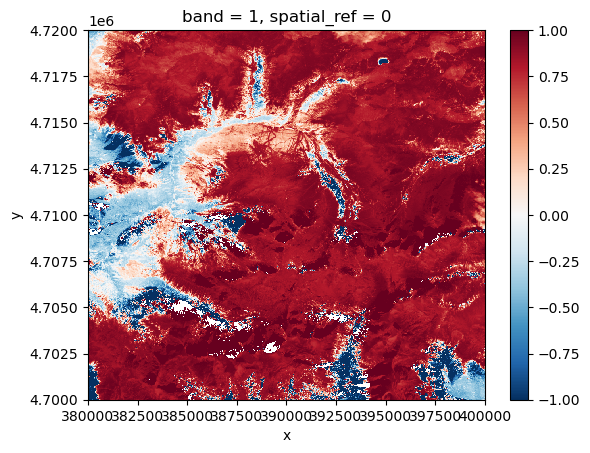

In [13]:
ndsi.plot()

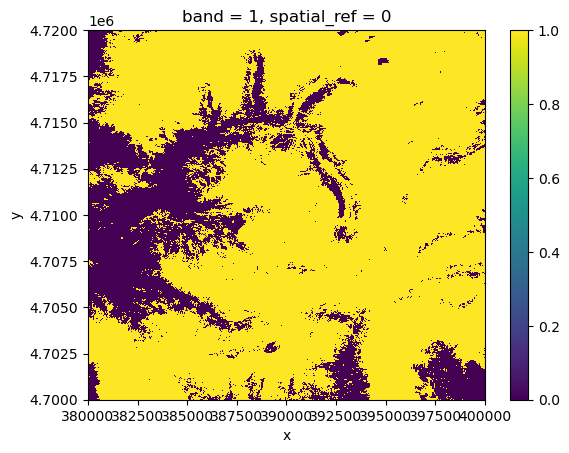

In [14]:
(ndsi > 0.4).plot()

In [15]:
sub_ds = xr.Dataset({"green": green, "swir": swir})
sub_ds

<xarray.Dataset> Size: 8MB
Dimensions:      (band: 1, x: 1000, y: 1000)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 8kB 3.8e+05 3.8e+05 3.8e+05 ... 4e+05 4e+05 4e+05
  * y            (y) float64 8kB 4.72e+06 4.72e+06 4.72e+06 ... 4.7e+06 4.7e+06
    spatial_ref  int64 8B 0
Data variables:
    green        (band, y, x) float32 4MB 132.8 198.5 ... 1.532e+03 1.488e+03
    swir         (band, y, x) float32 4MB 770.0 846.0 ... 2.314e+03 2.576e+03

In [16]:
sub_ds["ndsi"] = (sub_ds.green - sub_ds.swir) / (sub_ds.green + sub_ds.swir)
sub_ds["snow"] = sub_ds.ndsi > 0.4
sub_ds

<xarray.Dataset> Size: 13MB
Dimensions:      (band: 1, x: 1000, y: 1000)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 8kB 3.8e+05 3.8e+05 3.8e+05 ... 4e+05 4e+05 4e+05
  * y            (y) float64 8kB 4.72e+06 4.72e+06 4.72e+06 ... 4.7e+06 4.7e+06
    spatial_ref  int64 8B 0
Data variables:
    green        (band, y, x) float32 4MB 132.8 198.5 ... 1.532e+03 1.488e+03
    swir         (band, y, x) float32 4MB 770.0 846.0 ... 2.314e+03 2.576e+03
    ndsi         (band, y, x) float32 4MB -0.7059 -0.6199 ... -0.2035 -0.2676
    snow         (band, y, x) bool 1MB False False False ... False False False

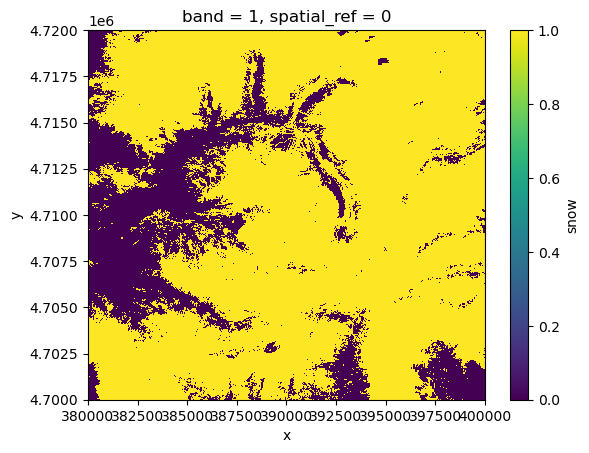

In [17]:
sub_ds.snow.plot()

In [18]:
sub_ds.snow.sum() / sub_ds.snow.size

<xarray.DataArray 'snow' ()> Size: 8B
array(0.772002)
Coordinates:
    spatial_ref  int64 8B 0

## Maintenant, calcul sur une image complète, avec Dask

Pour éviter les problèmes mémoire

In [19]:
client = Client(n_workers=2, nthreads=1, memory_limit='2GiB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 4.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40239,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 4.00 GiB
Comm: tcp://127.0.0.1:36871,Total threads: 1
Dashboard: http://127.0.0.1:35243/status,Memory: 2.00 GiB
Nanny: tcp://127.0.0.1:42683,


In [20]:
client.run(set_env)

{'tcp://127.0.0.1:36871': None, 'tcp://127.0.0.1:39267': None}

In [21]:
def read_one_band(product, band, coarsen=1):
    chunks=(-1, 2048*coarsen, 2048*coarsen)
    band = rioxarray.open_rasterio(f"gs://supaero/31TCH/{product}/{product}_FRE_{band}.tif", 
                                chunks=chunks,
                                lock=False).squeeze('band', drop=True)
    band = band.where(band != -10000)
    band.rio.write_nodata(-10000, encoded=True, inplace=True)
    if coarsen > 1:
        band = band.coarsen(x=coarsen, y=coarsen, boundary='pad').mean()
    return band

In [22]:
read_one_band("SENTINEL2B_20191224-104910-788_L2A_T31TCH_C_V2-2", "B3", 2)

<xarray.DataArray (y: 5490, x: 5490)> Size: 121MB
dask.array<mean_agg-aggregate, shape=(5490, 5490), dtype=float32, chunksize=(2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 44kB 3e+05 3e+05 3e+05 ... 4.098e+05 4.098e+05
  * y            (y) float64 44kB 4.8e+06 4.8e+06 4.8e+06 ... 4.69e+06 4.69e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [25]:
def create_dataset(product):
    ds = xr.Dataset({"green": read_one_band(product, "B3", 2), "swir": read_one_band(product, "B11")})
    ds["ndsi"] = (ds.green - ds.swir) / (ds.green + ds.swir)
    ds["snow"] = ds.ndsi > 0.4
    return ds

In [26]:
create_dataset("SENTINEL2B_20191224-104910-788_L2A_T31TCH_C_V2-2")

<xarray.Dataset> Size: 392MB
Dimensions:      (x: 5490, y: 5490)
Coordinates:
  * x            (x) float64 44kB 3e+05 3e+05 3e+05 ... 4.098e+05 4.098e+05
  * y            (y) float64 44kB 4.8e+06 4.8e+06 4.8e+06 ... 4.69e+06 4.69e+06
    spatial_ref  int64 8B 0
Data variables:
    green        (y, x) float32 121MB dask.array<chunksize=(2048, 2048), meta=np.ndarray>
    swir         (y, x) float32 121MB dask.array<chunksize=(2048, 2048), meta=np.ndarray>
    ndsi         (y, x) float32 121MB dask.array<chunksize=(2048, 2048), meta=np.ndarray>
    snow         (y, x) bool 30MB dask.array<chunksize=(2048, 2048), meta=np.ndarray>

In [32]:
product_list = [path.split("/")[-1] for path in fs.ls('supaero/31TCH')]

In [33]:
datasets = []
for product in product_list:
    datasets.append(create_dataset(product))
datasets

[<xarray.Dataset> Size: 392MB
 Dimensions:      (x: 5490, y: 5490)
 Coordinates:
   * x            (x) float64 44kB 3e+05 3e+05 3e+05 ... 4.098e+05 4.098e+05
   * y            (y) float64 44kB 4.8e+06 4.8e+06 4.8e+06 ... 4.69e+06 4.69e+06
     spatial_ref  int64 8B 0
 Data variables:
     green        (y, x) float32 121MB dask.array<chunksize=(2048, 2048), meta=np.ndarray>
     swir         (y, x) float32 121MB dask.array<chunksize=(2048, 2048), meta=np.ndarray>
     ndsi         (y, x) float32 121MB dask.array<chunksize=(2048, 2048), meta=np.ndarray>
     snow         (y, x) bool 30MB dask.array<chunksize=(2048, 2048), meta=np.ndarray>,
 <xarray.Dataset> Size: 392MB
 Dimensions:      (x: 5490, y: 5490)
 Coordinates:
   * x            (x) float64 44kB 3e+05 3e+05 3e+05 ... 4.098e+05 4.098e+05
   * y            (y) float64 44kB 4.8e+06 4.8e+06 4.8e+06 ... 4.69e+06 4.69e+06
     spatial_ref  int64 8B 0
 Data variables:
     green        (y, x) float32 121MB dask.array<chunksize=(2048, 20

In [34]:
complete_ds = xr.concat(datasets, "time")
complete_ds

<xarray.Dataset> Size: 4GB
Dimensions:      (time: 10, y: 5490, x: 5490)
Coordinates:
  * x            (x) float64 44kB 3e+05 3e+05 3e+05 ... 4.098e+05 4.098e+05
  * y            (y) float64 44kB 4.8e+06 4.8e+06 4.8e+06 ... 4.69e+06 4.69e+06
    spatial_ref  int64 8B 0
Dimensions without coordinates: time
Data variables:
    green        (time, y, x) float32 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    swir         (time, y, x) float32 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    ndsi         (time, y, x) float32 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    snow         (time, y, x) bool 301MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>

In [36]:
complete_ds.snow.sum(dim=["x", "y"]).compute()

/srv/conda/envs/notebook/lib/python3.12/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/srv/conda/envs/notebook/lib/python3.12/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


<xarray.DataArray 'snow' (time: 10)> Size: 80B
array([ 125967,   15257, 5091199, 2080172, 1692598,  751114,  118408,
         78515, 9500590, 2531979])
Coordinates:
    spatial_ref  int64 8B 0
Dimensions without coordinates: time